# Graphical Models for Textual Data
This shows how graphical models can be used to infer relationships between textual data.

In [2]:
from collections import Counter

import pandas as pd
from regain.utils import flatten
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from regainapp import base; import imp; imp.reload(base)
train, test = base.load_webkb()

1 - create data manually (no filtering on terms)

In [3]:
# compute the dictionary of the words (only strings)
words = np.unique(flatten([words.split(' ') for words in train.words.tolist() if isinstance(words, str)]))

# for each document, create the TermFrequency
tf_docs = [dict(Counter(v.split(' '))) for k, v in train.itertuples() if isinstance(v, str)]
assert len(tf_docs) == len(train)

# build data
X = pd.DataFrame(tf_docs, index=[row.Index for row in train.itertuples()
      if isinstance(row.words, str)]).fillna(0)
y = X.index

2 - create data with some filters based on sklearn-`CountVectorizer`

In [4]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=1., min_df=0.) #, stop_words='english')
tf = tf_vectorizer.fit_transform(train.values.flatten())

df_tf = pd.DataFrame(tf.todense(), index=train.index, columns=tf_vectorizer.get_feature_names())

In [5]:
np.allclose(X, df_tf)

True

In [7]:
# # NMF is able to use tf-idf
# tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
# tfidf = tfidf_vectorizer.fit_transform(documents)
# tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# # Run NMF
# nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
# nmf_W = nmf_model.transform(tfidf)
# nmf_H = nmf_model.components_

# print("NMF Topics")
# display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, no_top_words, no_top_documents)

In [8]:
n_topics = 50

In [ ]:
# Run LDA
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online',
                                      learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

from regain import utils_text; imp.reload(utils_text)

print("LDA Topics")
topics = utils_text.display_topics(lda_H, lda_W, tf_vectorizer.get_feature_names(),
                                   train.values.flatten(), n_top_words=4, n_top_documents=1, print_docs=False)

df = pd.DataFrame(lda_W, index=train.index, columns=topics)

## LogEntropyModel (`regain`)

In [10]:
words_to_discard = []
for yy in np.unique(y):
    words_to_discard += list(X[words[X[y==yy].sum(axis=0) == 0]].columns)

words_to_keep = list(set(X.columns) - set(words_to_discard))

X_new = utils_text.logentropy_normalize(X)[words_to_keep]

/Users/federicot/src/fdtomasi/regain/regain/utils_text.py:30: RuntimeWarning: divide by zero encountered in log
  E = 1 + (P * np.log(P)).fillna(0).values.sum(


## LogEntropyModel (`gensim`)

In [11]:
from gensim.models import LogEntropyModel, LdaModel
from gensim.test.utils import common_texts
from gensim.corpora import Dictionary

corp = [w.split(' ') for w in train.words if isinstance(w, str)]
text = corp #common_texts
dct = Dictionary(text)  # fit dictionary

num_terms = 50 # or words.size
dct.filter_extremes(keep_n=num_terms)

corpus = [dct.doc2bow(row) for row in text]  #convert to BoW format
model = LogEntropyModel(corpus, normalize=True)  # fit model

# model = models.LdaModel(corpus, id2word=dct, num_topics=num_terms)

import gensim
X_new = gensim.matutils.corpus2dense(model[corpus], num_terms=num_terms).T
df_new = pd.DataFrame(X_new, columns=list(dct.values()), index=y)

# df[words_to_keep].T.sort_index().T
# X = df[words_to_keep].values

# X = df.values
# y = df.index

/Users/federicot/miniconda3/lib/python3.7/site-packages/gensim/matutils.py:491: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


In [12]:
from sklearn.covariance import GraphicalLasso
gl = GraphicalLasso(alpha=0.002).fit(X_new)

In [12]:
relations = [(df_new.columns[i], df_new.columns[j]) for i, j in zip(*np.nonzero(gl.precision_))]

from gensim.models.poincare import PoincareModel
model = PoincareModel(relations, negative=2)
model.train(epochs=50)

model.kv.ancestors('student')

model.kv.descendants('student')

embeddings = np.array([model.kv.get_vector(x) for x in df_new.columns])

from sklearn.decomposition import PCA
embs_2d = PCA(n_components=2).fit_transform(embeddings)

embs = pd.DataFrame(embs_2d, index=df_new.columns, columns='x y'.split()).reset_index()

ee = embs.set_index('index')

import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "none"

edge_x = []
edge_y = []
for src, dst in relations:
    x0, y0 = ee.loc[src].values
    x1, y1 = ee.loc[dst].values
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_trace = go.Scatter(
    x=embs_2d[:, 0], y=embs_2d[:, 1],
    mode='markers',
    hoverinfo='text',
    text=df_new.columns)

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

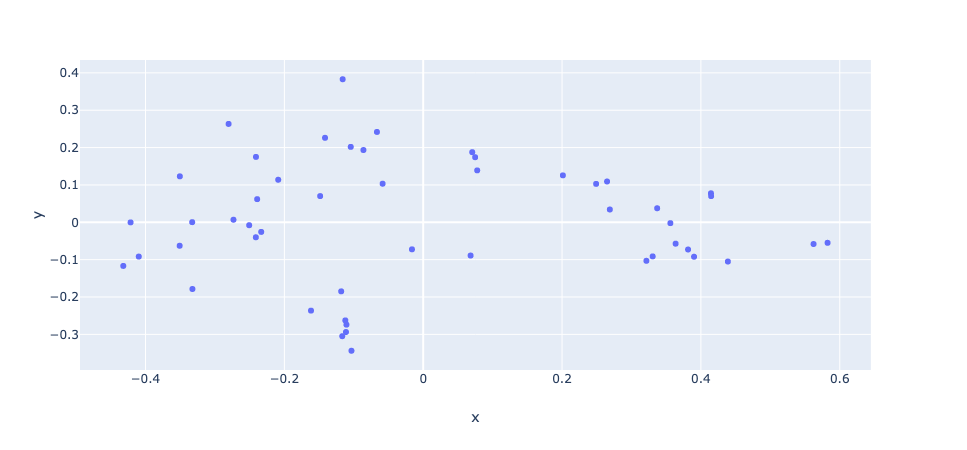

In [27]:
import plotly.express as px
fig = px.scatter([embs, ], x="x", y="y", hover_data=['index'])
fig.show()

In [12]:
from regain.covariance import kernel_time_graphical_lasso_
from regain.model_selection import stability_optimization
from sklearn.model_selection import StratifiedShuffleSplit

mdl = kernel_time_graphical_lasso_.KernelTimeGraphicalLasso(
    verbose=0, kernel=np.ones((np.unique(y).size, np.unique(y).size)), psi='l1',
    alpha=0.45, max_iter=1000).fit(X_new, y)

In [13]:
imp.reload(stability_optimization);
socv = stability_optimization.GraphicalModelStabilitySelection(
    mdl, param_grid=dict(alpha=np.logspace(2, -2)),
    sampling_size=200,
).fit(X_new, y)

KeyboardInterrupt: 

In [ ]:
n_times = np.unique(y).size
n_dim = X_new.shape[1]

In [ ]:
idx = np.triu_indices(n_dim, 1)
dof = idx[0].size * n_times

In [ ]:
mdl = socv.best_estimator_

In [ ]:
print("Nonzero percentage: %.4f" % (np.sum([np.count_nonzero(P[idx]) for P in mdl.precision_]) / dof))

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from kdge import plot_plotly
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

py.init_notebook_mode()
import plotly.io as pio

In [ ]:
p = mdl.precision_[0]

In [ ]:
from regain.utils import retain_top_n

In [ ]:
k = -1
trace = []
graphs = []
# for i, p in enumerate(ltgl.precision_ - ltgl.latent_):
for i, p in enumerate(mdl.precision_):

    A = np.abs(p - np.diag(np.diag(p)))
    A = retain_top_n(A, top_n)
    G = nx.from_numpy_matrix(A * 0.00001)
    graphs.append(G)
    trace.append(pl.plot_circular(G, df.columns, 1.4, cmap='Blues',
                                  #color_nodes=plt.rcParams['axes.prop_cycle'].by_key()['color'][:5]
                                 ))

fig = tools.make_subplots(
    rows=1, cols=len(mdl.precision_), horizontal_spacing=.1, print_grid=False)

for j, tr in enumerate(trace):
    tr['data'][k]['xaxis'] = 'x' + str(j+1)
    tr['data'][k]['yaxis'] = 'y' + str(j+1)

for j, tr in enumerate(trace):
    for i, x in enumerate(tr['data']):
        col = j + 1
        x['legendgroup'] = 'group'+ str(j+1)
        x['showlegend'] = False
        fig.append_trace(x,1,col)
        


for j, tr in enumerate(trace):
    fig.layout.annotations += tuple([pl._set_ref(
        x, 'x'+ str(j+1), 'y'+ str(j+1)) for x in tr['layout']['annotations']])

    fig['layout']['xaxis'+str(j+1)].update(showgrid=False, zeroline=False, showticklabels=False)
    fig['layout']['yaxis'+str(j+1)].update(showgrid=False, zeroline=False, showticklabels=False)

py.init_notebook_mode()

fig['layout'].update(height=900, width=4000,hovermode='closest',
                     paper_bgcolor='rgba(0,0,0,0)',
                        plot_bgcolor='rgba(0,0,0,0)')
# fig.layout.annotations += tuple([dict(
#     text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
#     showarrow=False, xref="paper", yref="paper", x=0.005, y=-0.2)])
# fig['layout'].update(scene=dict(aspectmode="data"))
py.iplot(fig)
# py.offline.iplot(fig, filename='figure_factory_subplot', image='svg')

In [ ]:
pio.write_image(fig, "graphs.pdf")

## Correlated Topic Model

In [ ]:
import ctmmodel
ctm_model = ctmmodel.CtmModel(corpus, id2word=dct, num_topics=15)

all_words = []
for c in corpus:
    doc_words = []
    for cc in c:
        doc_words.extend([dct[cc[0]]] * cc[1])
    all_words.append(' '.join(doc_words))

In [ ]:
import pyctm
from pyctm import variational_bayes, inferencer, utils

In [ ]:
# parameter set 3
alpha_mu=0.
alpha_sigma=1
alpha_beta=0

ctm_inferencer = variational_bayes.VariationalBayes();
ctm_inferencer._initialize(
    all_words, list(dct.values()),
    number_of_topics=15,
    alpha_mu=alpha_mu, alpha_sigma=alpha_sigma,
    alpha_beta=alpha_beta);
# ctm_inferencer._initialize(train.words.tolist(), words, 20,
#                            alpha_mu, alpha_sigma, alpha_beta);

for iteration in range(50):
    ctm_inferencer.learning(-1)

logl, lamda, nu = ctm_inferencer.inference(all_words)
# logl, lamda, nu = ctm_inferencer.inference(train.words.tolist())

ll = utils.topic_beta(ctm_inferencer)

topic_words = pd.DataFrame(ll)

In [ ]:
topic_str_repr = []
for row in topic_words.iterrows():
    print(pd.DataFrame(row[1].sort_values(ascending=False)[:3]).T)
    topic_str_repr.append(' '.join(row[1].sort_values(ascending=False)[:3].index))

word_dct_values = list(dct.values())

dff = pd.DataFrame(ctm_model.beta, columns=word_dct_values)
dff = dff[sorted(dff.columns)]

In [ ]:
import numpy as np
from sklearn.covariance import GraphicalLassoCV

from regain import utils

In [ ]:
gl = GraphicalLassoCV().fit(lamda)

In [ ]:
p = gl.precision_

A = np.abs(p - np.diag(np.diag(p)))
A = retain_top_n(A, 20)
G = nx.from_numpy_matrix(A * 3)
fig = pl.plot_circular(G, topic_str_repr, 2, cmap='Blues')

fig['layout'].update(height=800, width=800,hovermode='closest',
                     paper_bgcolor='rgba(0,0,0,0)',
                        plot_bgcolor='rgba(0,0,0,0)')
# fig.layout.annotations += tuple([dict(
#     text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
#     showarrow=False, xref="paper", yref="paper", x=0.005, y=-0.2)])
# fig['layout'].update(scene=dict(aspectmode="data"))
py.iplot(fig)
# py.offline.iplot(fig, filename='figure_factory_subplot', image='svg')